# Inspect YOLOv1 Model

In [1]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import VOCDetection, wrap_dataset_for_transforms_v2
from torchvision.transforms import v2
from torchvision.tv_tensors._dataset_wrapper import VOC_DETECTION_CATEGORIES, VOC_DETECTION_CATEGORY_TO_IDX
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert, clip_boxes_to_image, nms, batched_nms
from torchmetrics.detection import MeanAveragePrecision
from torchinfo import summary
import sys
sys.path.append('../')
from model.yolov1 import Yolov1Config, Yolov1
from torch.utils.tensorboard import SummaryWriter
# palette is a list of color tuples, which is used for visualization.
palette =  [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
            (197, 226, 255), (0, 60, 100), (0, 0, 142), (255, 77, 255),
            (153, 69, 1), (120, 166, 157), (0, 182, 199),
            (0, 226, 252), (182, 182, 255), (0, 0, 230), (220, 20, 60),
            (163, 255, 0), (0, 82, 0), (3, 95, 161), (0, 80, 100),
            (183, 130, 88)]

## Inspect structure

In [ ]:
img_h, img_w = 448, 448
n_class = 20
n_bbox_per_cell = 2
n_grid_h, n_grid_w = 7, 7

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    n_bbox_per_cell=n_bbox_per_cell,
    n_grid_h=n_grid_h,
    n_grid_w=n_grid_w
)
model_config = Yolov1Config(**model_args)
model = Yolov1(model_config)

batch_size = 1
summary(model, input_size=[(batch_size, 3, img_h, img_w), (batch_size, n_grid_h, n_grid_w, 1+1+4)], device='cuda',
        col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"), verbose=2,
        depth=4, row_settings=("depth", "var_names"));

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds                 Trainable
Yolov1 (Yolov1)                               [1, 3, 448, 448]          [1, 7, 7, 30]             --                        --                        --                        True
├─ExtractionBackbone (backbone): 1-1          [1, 3, 448, 448]          [1, 1024, 14, 14]         --                        --                        --                        True
│    └─conv1.conv.weight                                                                          ├─9,408                   [64, 3, 7, 7]
│    └─conv1.bn.weight                                                                            ├─64                      [64]
│    └─conv1.bn.bias                                                                              ├─64                      [64]
│    └─conv2.conv.weight                                

In [ ]:
writer = SummaryWriter()
imgs = torch.randn(batch_size, 3, img_h, img_w)
targets = torch.randn(batch_size, n_grid_h, n_grid_w, 1+1+4)
writer.add_graph(model, [imgs, targets])
writer.close()

/home/alvin/Projects/Alvin/yolov1/test/../model/yolov1.py:76: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  loss = torch.tensor(0.0, dtype=logits.dtype, device=logits.device)
/home/alvin/Projects/Alvin/yolov1/test/../model/yolov1.py:77: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for logits_per_img, targets_per_img in zip(logits, targets):
/home/alvin/Projects/Alvin/yolov1/test/../model/yolov1.py:80: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value

In [ ]:
logits, loss = model(imgs, targets)
print(logits.shape)
print(loss.shape)

torch.Size([1, 7, 7, 30])
torch.Size([])


## Inspect state_dict

In [ ]:
import tempfile

# Save state_dict as a temporary file
with tempfile.NamedTemporaryFile(suffix='.pth') as temp_file:
    torch.save(model.state_dict(), temp_file.name)
    state_dict = torch.load(temp_file.name)

# Print the keys of the state_dict
for key in state_dict.keys():
    print(key)


backbone.conv1.conv.weight
backbone.conv1.bn.weight
backbone.conv1.bn.bias
backbone.conv1.bn.running_mean
backbone.conv1.bn.running_var
backbone.conv1.bn.num_batches_tracked
backbone.conv2.conv.weight
backbone.conv2.bn.weight
backbone.conv2.bn.bias
backbone.conv2.bn.running_mean
backbone.conv2.bn.running_var
backbone.conv2.bn.num_batches_tracked
backbone.conv3.conv.weight
backbone.conv3.bn.weight
backbone.conv3.bn.bias
backbone.conv3.bn.running_mean
backbone.conv3.bn.running_var
backbone.conv3.bn.num_batches_tracked
backbone.conv4.conv.weight
backbone.conv4.bn.weight
backbone.conv4.bn.bias
backbone.conv4.bn.running_mean
backbone.conv4.bn.running_var
backbone.conv4.bn.num_batches_tracked
backbone.conv5.conv.weight
backbone.conv5.bn.weight
backbone.conv5.bn.bias
backbone.conv5.bn.running_mean
backbone.conv5.bn.running_var
backbone.conv5.bn.num_batches_tracked
backbone.conv6.conv.weight
backbone.conv6.bn.weight
backbone.conv6.bn.bias
backbone.conv6.bn.running_mean
backbone.conv6.bn.runnin

## Inspect output, post-processing, prediction

In [5]:
img_h, img_w = 448, 448
n_class = 20
n_bbox_per_cell = 2
n_grid_h, n_grid_w = 7, 7

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    n_bbox_per_cell=n_bbox_per_cell,
    n_grid_h=n_grid_h,
    n_grid_w=n_grid_w
)
model_config = Yolov1Config(**model_args)
model = Yolov1(model_config)

In [6]:
from_ckpt = '../out/yolov1_voc/20240125-223320/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']
model.load_state_dict(state_dict)
model.to('cuda');

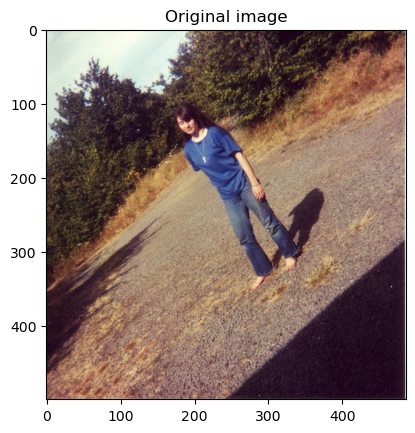

<class 'torchvision.tv_tensors._image.Image'>


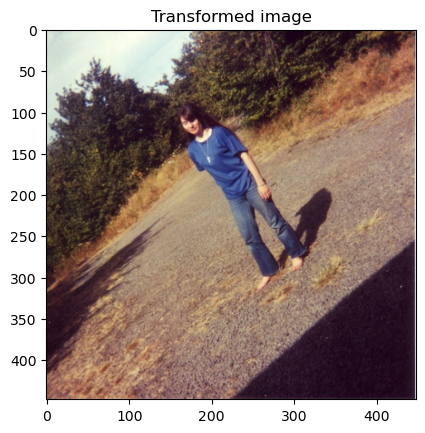

In [7]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(img_h, img_w), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])

x = Image.open('../data/voc/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg').convert("RGB")
plt.title('Original image')
plt.imshow(x)
plt.show()

x = transforms(x)
print(type(x))
plt.title('Transformed image')
plt.imshow(x.permute(1, 2, 0))
plt.show()

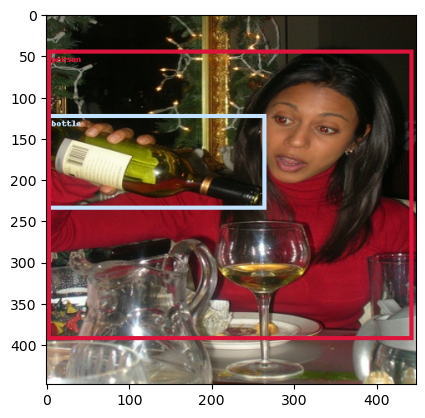

In [8]:
dataset = VOCDetection(root='../data/voc', year='2007', image_set='test', download=False,
                                                       transforms=transforms)
dataset_v2 = wrap_dataset_for_transforms_v2(dataset, target_keys=['boxes', 'labels'])

img, y = dataset_v2[76]
labels = [VOC_DETECTION_CATEGORIES[idx] for idx in y['labels']]
img_gt = draw_bounding_boxes(v2.functional.to_dtype(img, torch.uint8, scale=True), labels=labels, boxes=y['boxes'], colors=[palette[idx-1] for idx in y['labels']], width=5)
plt.imshow(img_gt.permute(1, 2, 0).numpy())
plt.show()

torch.Size([1, 7, 7, 30])
grid (2, 4)
  class: person (0.94)
  bbox 1 confidence: 0.26, probability: 0.2438


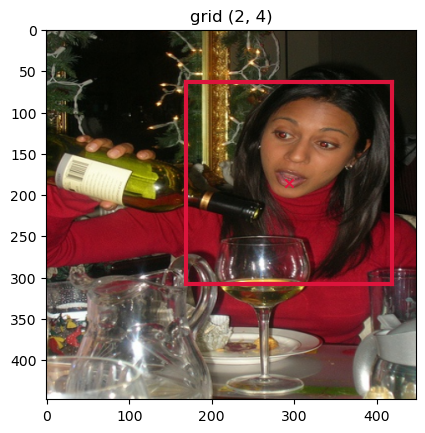

grid (3, 1)
  class: person (0.73)
  bbox 1 confidence: 0.53, probability: 0.3877


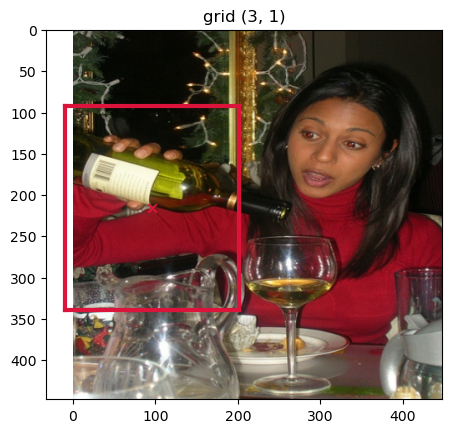

grid (3, 4)
  class: person (1.03)
  bbox 1 confidence: 0.65, probability: 0.6666


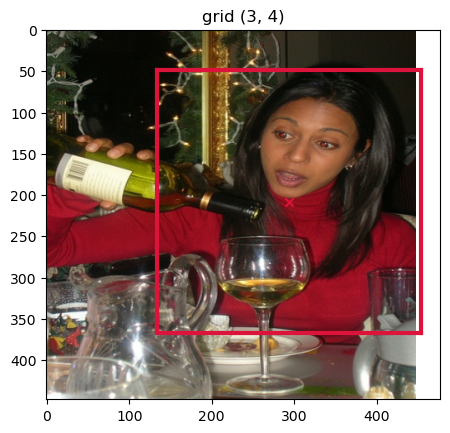

grid (5, 3)
  class: diningtable (0.83)
  bbox 1 confidence: 0.29, probability: 0.2425


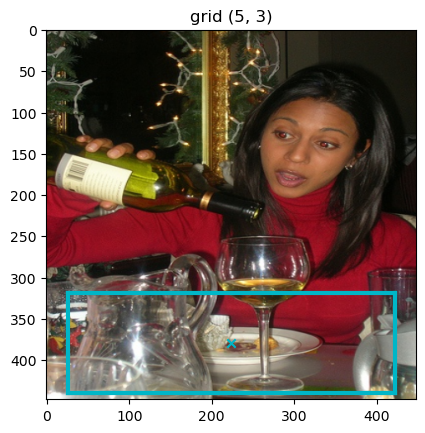

grid (6, 3)
  class: diningtable (0.91)
  bbox 0 confidence: 0.31, probability: 0.2830


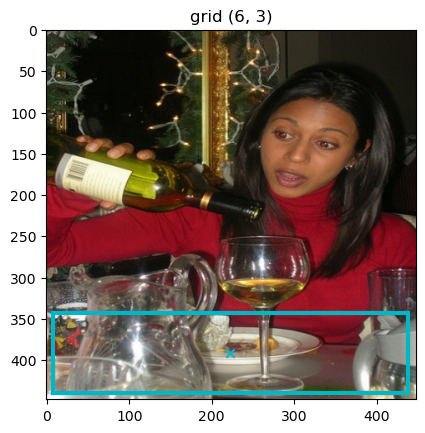

In [9]:
model.eval()
batch_size = 1
prob_thresh = 0.2
with torch.no_grad():
    imgs = torch.unsqueeze(img, dim=0)
    imgs = imgs.to('cuda')
    logits, loss = model(imgs)
    logits = logits.to('cpu')
    print(logits.shape)
    for grid_y in range(n_grid_h):
        for grid_x in range(n_grid_w):
            for idx_class in range(n_class):
                prob_class = logits[0, grid_y, grid_x, idx_class]
                for idx_bbox in range(n_bbox_per_cell):
                    conf = logits[0, grid_y, grid_x, n_class + idx_bbox * 5]
                    prob = prob_class * conf
                    if prob > prob_thresh:
                        print(f"grid ({grid_y}, {grid_x})")
                        print(f"  class: {VOC_DETECTION_CATEGORIES[idx_class+1]} ({prob_class:.2f})")
                        print(f"  bbox {idx_bbox} confidence: {conf:.2f}, probability: {prob:.4f}")
                        cx, cy, w, h = logits[0, grid_y, grid_x, n_class + idx_bbox * 5 + 1 : n_class + idx_bbox * 5 + 5]
                        cx = (cx + grid_x) / n_grid_w * img_w
                        cy = (cy + grid_y) / n_grid_h * img_h
                        w = (w ** 2) * img_w
                        h = (h ** 2) * img_h
                        plt.title(f"grid ({grid_y}, {grid_x})")
                        plt.imshow(img.permute(1, 2, 0))
                        plt.scatter(cx, cy, marker='x', color=np.array(palette[idx_class], dtype=float) / 255.0)
                        x1 = cx - w/2
                        y1 = cy - h/2
                        x2 = cx + w/2
                        y2 = cy + h/2
                        plt.plot([x1, x2], [y1, y1], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
                        plt.plot([x1, x2], [y2, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
                        plt.plot([x1, x1], [y1, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
                        plt.plot([x2, x2], [y1, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
                        plt.show()


## Inspect mAP

In [2]:
img_h, img_w = 448, 448
n_class = 20
n_bbox_per_cell = 2
n_grid_h, n_grid_w = 7, 7

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    n_bbox_per_cell=n_bbox_per_cell,
    n_grid_h=n_grid_h,
    n_grid_w=n_grid_w
)
model_config = Yolov1Config(**model_args)
model = Yolov1(model_config)

from_ckpt = '../out/yolov1_voc/20240130-030354/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']
model.load_state_dict(state_dict)
model.to('cuda');

In [3]:
batch_size = 256

class Voc2Yolov1(nn.Module):
    def forward(self, x, y_voc):
        boxes_yolov1 = y_voc['boxes'].clone()
        # Transform the bounding boxes from xyxy to cxcywh normalized by the image size
        boxes_yolov1 = box_convert(boxes_yolov1, in_fmt='xyxy', out_fmt='cxcywh')
        boxes_yolov1[:, [0, 2]] /= img_w
        boxes_yolov1[:, [1, 3]] /= img_h
        # Randomly shuffle the bounding boxes and labels, since only one object can be assigned to a grid cell
        idx = torch.randperm(len(boxes_yolov1))
        y_voc['boxes'] = y_voc['boxes'][idx]
        boxes_yolov1 = boxes_yolov1[idx]
        y_voc['labels'] = y_voc['labels'][idx] - 1  # remove background class
        y_yolov1 = torch.zeros((n_grid_h, n_grid_w, 1 + 1 + 4), dtype=torch.float32)
        cx_yolov1, cy_yolov1, w_yolov1, h_yolov1 = torch.unbind(boxes_yolov1, dim=1)
        grid_x = torch.clamp_max(torch.floor(cx_yolov1 * n_grid_w), (n_grid_w - 1)).to(torch.int64)
        grid_y = torch.clamp_max(torch.floor(cy_yolov1 * n_grid_h), (n_grid_h - 1)).to(torch.int64)
        y_yolov1[grid_y, grid_x, 0] = 1.0  # set the is_obj to 1.0
        y_yolov1[grid_y, grid_x, 1] = y_voc['labels'].to(torch.float32)  # set the class index to label
        # Set the bbox coordinates, x,y are normalized by the grid size
        y_yolov1[grid_y, grid_x, 2] = cx_yolov1 * n_grid_w - grid_x
        y_yolov1[grid_y, grid_x, 3] = cy_yolov1 * n_grid_h - grid_y
        y_yolov1[grid_y, grid_x, 4] = torch.sqrt(w_yolov1)
        y_yolov1[grid_y, grid_x, 5] = torch.sqrt(h_yolov1)
        return x, y_yolov1, y_voc


transforms_val = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(img_h, img_w), antialias=True),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    Voc2Yolov1(),
])

dataset_val = VOCDetection('../data/voc', year='2007', image_set='test', transforms=transforms_val)
dataset_val = wrap_dataset_for_transforms_v2(dataset_val, target_keys=['boxes', 'labels'])
def collate_fn(batch):
    xs, ys, y_supps = [], [], []
    for x, y, y_supp in batch:
        xs.append(x)
        ys.append(y)
        y_supps.append(y_supp)
    return torch.stack(xs), torch.stack(ys), y_supps
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False,  # shuffle since eval on only partial data
                            num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [5]:
prob_thresh = 0.001
iou_thresh = 0.5
# Compute mAP by torchmetrics
metric = MeanAveragePrecision(iou_type='bbox')#, extended_summary=True)  # extended_summary=True cannot be used with metric.plot()

with torch.inference_mode():
    model.eval()
    for x, y, y_supp in dataloader_val:
        x = x.to('cuda')
        y = y.to('cuda')
        device = x.device
        logits, loss = model(x, y)

        preds_for_map, targets_for_map = [], []
        for idx_img in range(len(x)):
            logits_per_img = logits[idx_img]
            # Convert to boxes_for_nms, scores_for_nms, classes_for_nms
            grid_y, grid_x, idx_class, idx_bbox = torch.meshgrid(torch.arange(n_grid_h, device=device),
                                                                 torch.arange(n_grid_w, device=device),
                                                                 torch.arange(n_class, device=device),
                                                                 torch.arange(n_bbox_per_cell, device=device),
                                                                 indexing='ij')
            prob_class = logits_per_img[grid_y, grid_x, idx_class]
            conf = logits_per_img[grid_y, grid_x, n_class + idx_bbox * 5]
            prob = prob_class * conf
            mask = (prob > prob_thresh) & (conf > 0.0)
            grid_y = grid_y[mask]
            grid_x = grid_x[mask]
            idx_class = idx_class[mask]
            idx_bbox = idx_bbox[mask]
            prob = prob[mask]
            cx = logits_per_img[grid_y, grid_x, n_class + idx_bbox * 5 + 1]
            cy = logits_per_img[grid_y, grid_x, n_class + idx_bbox * 5 + 2]
            w = logits_per_img[grid_y, grid_x, n_class + idx_bbox * 5 + 3]
            h = logits_per_img[grid_y, grid_x, n_class + idx_bbox * 5 + 4]
            cx = (cx + grid_x) / n_grid_w * img_w
            cy = (cy + grid_y) / n_grid_h * img_h
            w = (w ** 2) * img_w
            h = (h ** 2) * img_h
            coord = torch.stack((cx, cy, w, h), dim=-1)

            # if len(coord) > 0:
            # labels = [VOC_DETECTION_CATEGORIES[idx+1] for idx in y_supp[idx_img]['labels']]
            # img_pred = draw_bounding_boxes(v2.functional.to_dtype(x[0].to('cpu'), torch.uint8, scale=True), labels=labels, boxes=y_supp[idx_img]['boxes'], colors=[palette[idx] for idx in y_supp[idx_img]['labels']], width=5)
            # plt.imshow(img_pred.permute(1, 2, 0).numpy())
            # plt.show()
            boxes_for_nms = clip_boxes_to_image(box_convert(coord, in_fmt='cxcywh', out_fmt='xyxy'), size=(img_h, img_w))
            scores_for_nms = prob
            classes_for_nms = idx_class

            # labels = [VOC_DETECTION_CATEGORIES[idx+1] for idx in classes_for_nms]
            # img_pred = draw_bounding_boxes(v2.functional.to_dtype(x[0].to('cpu'), torch.uint8, scale=True), labels=labels, boxes=boxes_for_nms, colors=[palette[idx] for idx in classes_for_nms], width=5)
            # plt.imshow(img_pred.permute(1, 2, 0).numpy())
            # plt.show()

            # print(boxes_for_nms.shape[0])
            keep = batched_nms(boxes_for_nms, scores_for_nms, classes_for_nms, iou_thresh)
            # print(keep.shape)

            boxes_for_map = boxes_for_nms[keep]
            scores_for_map = scores_for_nms[keep]
            classes_for_map = classes_for_nms[keep]
            # labels = [VOC_DETECTION_CATEGORIES[idx+1] for idx in classes_for_map]
            # img_pred = draw_bounding_boxes(v2.functional.to_dtype(x[0].to('cpu'), torch.uint8, scale=True), labels=labels, boxes=boxes_for_map, colors=[palette[idx] for idx in classes_for_map], width=5)
            # plt.imshow(img_pred.permute(1, 2, 0).numpy())
            # plt.show()

            preds_for_map.append(dict(boxes=boxes_for_map, scores=scores_for_map, labels=classes_for_map))
            targets_for_map.append(dict(boxes=y_supp[idx_img]['boxes'].to(device), labels=y_supp[idx_img]['labels'].to(device)))

        metric.update(preds_for_map, targets_for_map)

    print(metric.compute())  # 'map_50': tensor(0.5143), 51.1s

{'map': tensor(0.2479), 'map_50': tensor(0.5143), 'map_75': tensor(0.2144), 'map_small': tensor(0.0018), 'map_medium': tensor(0.0500), 'map_large': tensor(0.3654), 'mar_1': tensor(0.2749), 'mar_10': tensor(0.3527), 'mar_100': tensor(0.3614), 'mar_small': tensor(0.0156), 'mar_medium': tensor(0.1419), 'mar_large': tensor(0.4904), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], dtype=torch.int32)}


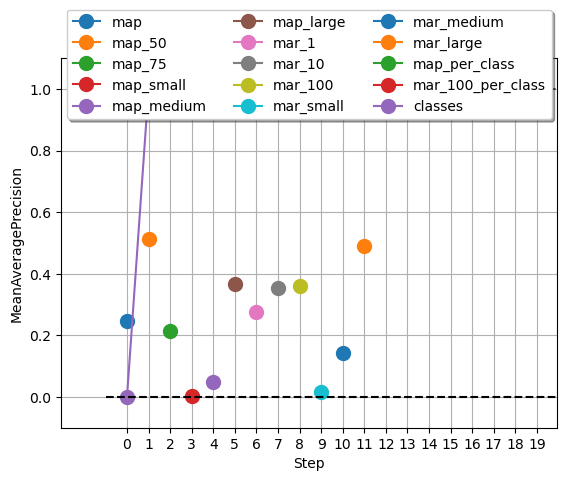

In [6]:
fig_, ax_ = metric.plot()  # plot() cannot be used with extended_summary=True
plt.show()